In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import (train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, StratifiedKFold, StratifiedShuffleSplit)
from sklearn.preprocessing import (PolynomialFeatures, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, classification_report)
from sklearn.utils import shuffle, resample
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

In [2]:
train_df = pd.read_csv("train_transformed_cleaned.csv")
test_df = pd.read_csv("test_transformed_cleaned.csv")
df_merged = pd.read_csv("df_merged.csv")

In [19]:
# mwra to numeric
df_merged['mwra'] = df_merged['mwra'].astype(int)

# Group-Based Splitting
groups = df_merged['username']  # Use 'username' as the grouping variable

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df_merged, groups=groups))

train_df = df_merged.iloc[train_idx].copy()
test_df = df_merged.iloc[test_idx].copy()

# Verify no overlapping users
train_users = set(train_df['username'])
test_users = set(test_df['username'])
user_overlap = train_users.intersection(test_users)
print(f"Number of overlapping users after split: {len(user_overlap)}")  # Should output 0

# Convert datetime columns to numeric format
datetime_cols = ['ts', 'registration', 'birthdate']
for col in datetime_cols:
    for df in [train_df, test_df]:
        # Convert to datetime
        df[col] = pd.to_datetime(df[col], errors='coerce')

        df[col] = df[col].astype('int64') / 1e9  # Convert to seconds since epoch

        # Ensure the column is of type float64
        df[col] = df[col].astype('float64')

# Label encoding
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn',
                 'name', 'mail', 'username', 'job']

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).astype(str)
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))
    label_encoders[col] = le

# Feature selection and target column
target_column = 'mwra'
selected_features = [
    'p.android.gm',
    'c.android.gm',
    'c.katana',
    'c.dogalize',
    'c.android.youtube',
    'p.android.externalstorage',
    'p.android.documentsui',
]

# Ensure selected features are in the DataFrame
missing_features = [feat for feat in selected_features if feat not in train_df.columns]
if missing_features:
    print(f"The following selected features are missing from the DataFrame: {missing_features}")

# Separate features and target for training and testing
X_train = train_df[selected_features]
y_train = train_df[target_column]
X_test = test_df[selected_features]
y_test = test_df[target_column]

# Verify overlap after feature selection using indices
overlap = set(X_train.index).intersection(set(X_test.index))
print(f"Number of overlapping samples after feature selection: {len(overlap)}") 

clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Prediction on the test set
y_pred = clf.predict(X_test)

# Evaluation metrics (accuracy, precision, recall)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)

# Overfitting check
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
overfit = train_accuracy > test_accuracy + 0.1  # overfit check

# Output results
evaluation_results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Overfit": overfit
}

# Display evaluation results
print(evaluation_results)

Number of overlapping users after split: 0
Number of overlapping samples after feature selection: 0
{'Accuracy': 0.9269810715431505, 'Precision': 0.9267826074396608, 'Recall': 0.9269810715431505, 'Train Accuracy': 0.9328488763288925, 'Test Accuracy': 0.9269810715431505, 'Overfit': False}


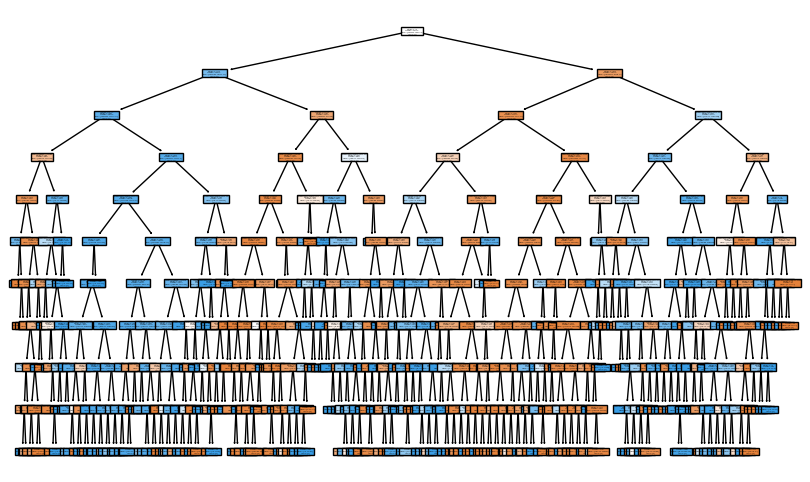

In [17]:
plt.figure(figsize=(10, 6))
plot_tree(clf, feature_names=selected_features, class_names=True, filled=True)
plt.show()

In [25]:
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,
    criterion='entropy',
    max_depth=9,
    random_state=42,
    class_weight='balanced'
)

# Train the classifier
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)

In [26]:
# Initialize the Logistic Regression Classifier
lr_clf = LogisticRegression(
    solver='liblinear',
    class_weight='balanced',
    random_state=42
)

# Train the classifier
lr_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_clf.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)

In [27]:
# ID3 Decision Tree Classifier (from previous steps)
clf = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=9,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)

y_pred_id3 = clf.predict(X_test)

# Evaluate the model
accuracy_id3 = accuracy_score(y_test, y_pred_id3)
precision_id3 = precision_score(y_test, y_pred_id3, average='weighted', zero_division=0)
recall_id3 = recall_score(y_test, y_pred_id3, average='weighted', zero_division=0)

In [28]:
# Compile results into a DataFrame
import pandas as pd

evaluation_df = pd.DataFrame({
    'Model': ['ID3 Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [accuracy_id3, accuracy_rf, accuracy_lr],
    'Precision': [precision_id3, precision_rf, precision_lr],
    'Recall': [recall_id3, recall_rf, recall_lr]
})

print("\nComparison of Classifier Performance:")
print(evaluation_df)


Comparison of Classifier Performance:
                 Model  Accuracy  Precision    Recall
0    ID3 Decision Tree  0.922233   0.922101  0.922233
1        Random Forest  0.927997   0.927939  0.927997
2  Logistic Regression  0.909496   0.909164  0.909496


In [32]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=selected_features,
    class_names=['False', 'True'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_visualization")

NameError: name 'tree' is not defined

In [ ]:
# Load and split data
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42) #krosvalidacia
overlap = set(train_df.index).intersection(set(test_df.index))
print(f"Number of overlapping samples after split: {len(overlap)}")  # Should output 0

# Preprocessing
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
for col in ['mwra', 'IsRegistrationDefined', 'IsBirthdateDefined']:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

for col in ['ts', 'registration', 'birthdate']:
    if train_df[col].dtype == 'object':
        train_df[col] = pd.to_datetime(train_df[col]).astype(int) / 10**9
        test_df[col] = pd.to_datetime(test_df[col]).astype(int) / 10**9

minmax_columns = ['ts', 'imei', 'birthdate', 'registration', 'job', 'store_name', 'code', 'location', 
                  'residence', 'company', 'ssn', 'name', 'mail', 'username']
other_columns = list(set(numeric_features) - set(minmax_columns))
label_columns = ['store_name', 'code', 'location', 'residence', 'company', 'ssn', 'name', 'mail', 'username', 'job']

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], test_df[col]]).unique()
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

pipeline_part1 = Pipeline(steps=[
    ('quantile_transform', QuantileTransformer(output_distribution='normal')), 
    ('minmax_scaler', MinMaxScaler())  
])

pipeline_part2 = Pipeline(steps=[
    ('power_transform', PowerTransformer(method='yeo-johnson')), 
    ('standard_scaler', StandardScaler()) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', pipeline_part1, minmax_columns),
        ('scaler', pipeline_part2, other_columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = train_df.drop(columns=['mwra'])
y_train = train_df['mwra']
X_test = test_df.drop(columns=['mwra'])
y_test = test_df['mwra']

pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Retrieve feature names from the ColumnTransformer
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Decision Tree Hyperparameter Tuning
print("Optimalizácia hyperparametrov pre Decision Tree...")
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_transformed, y_train)
best_tree = grid_search_dt.best_estimator_
print(f"Najlepšie parametre Decision Tree: {grid_search_dt.best_params_}")

# Evaluate Tuned Decision Tree
y_pred_dt = best_tree.predict(X_test_transformed)
evaluate_model = lambda name, y_true, y_pred: print(
    f"{name} Model:\n  Accuracy: {accuracy_score(y_true, y_pred):.4f}\n  Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}\n  Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}\n" + "-"*30
)
evaluate_model("Tuned Decision Tree", y_test, y_pred_dt)

# Bagging Classifier
print("Trénovanie kombinovaných modelov...")
bagging_clf = BaggingClassifier(estimator=best_tree, n_estimators=10, random_state=42, n_jobs=-1)
bagging_clf.fit(X_train_transformed, y_train)
y_pred_bagging = bagging_clf.predict(X_test_transformed)
evaluate_model("Bagging Classifier", y_test, y_pred_bagging)

# Random Forest Hyperparameter Tuning
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

randomized_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=4, 
    cv=3, 
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train_transformed, y_train)
best_rf = randomized_search_rf.best_estimator_

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test_transformed)
evaluate_model("Random Forest", y_test, y_pred_rf)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_dt = cross_val_score(best_tree, X_train_transformed, y_train, cv=cv, scoring='accuracy')
cv_scores_bagging = cross_val_score(bagging_clf, X_train_transformed, y_train, cv=cv, scoring='accuracy')
cv_scores_rf = cross_val_score(best_rf, X_train_transformed, y_train, cv=cv, scoring='accuracy')

print("\nKrížová validácia na trénovacej množine...")
print(f"Tuned Decision Tree CV Accuracy: {np.mean(cv_scores_dt):.4f}")
print(f"Bagging Classifier CV Accuracy: {np.mean(cv_scores_bagging):.4f}")
print(f"Random Forest CV Accuracy: {np.mean(cv_scores_rf):.4f}")

# Overfitting Check
print("\nOverenie absencie overfitu...")
print(f"Tuned Decision Tree Overfit: {'No' if best_tree.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_dt) <= 0.1 else 'Yes'}")
print(f"Bagging Classifier Overfit: {'No' if bagging_clf.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_bagging) <= 0.1 else 'Yes'}")
print(f"Random Forest Overfit: {'No' if best_rf.score(X_train_transformed, y_train) - accuracy_score(y_test, y_pred_rf) <= 0.1 else 'Yes'}")


Number of overlapping samples after split: 0
Optimalizácia hyperparametrov pre Decision Tree...


In [ ]:
#verifikacia mnozin
#shuffle
#oversampling/under